In [17]:
import time
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment
from matplotlib import pyplot as plt
from collections import Counter
import numpy as np

def create_dataset_torch(dataset_name, dataset_dir, batch_size=64, test_size=0.2, random_state=42):
    # 定义数据转换
    if dataset_name == 'CIFAR10':
        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2023, 0.1994, 0.2010]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        dataset = torchvision.datasets.CIFAR10(root=dataset_dir, train=True, 
                                              download=True, transform=transform)
    elif dataset_name == 'MNIST':
        mean = [0.1307]
        std = [0.3081]
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ])
        dataset = torchvision.datasets.MNIST(root=dataset_dir, train=True,
                                            download=True, transform=transform)
    else:
        raise ValueError(f"不支持的数据集: {dataset_name}")
    
    # 创建数据加载器
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           shuffle=True, drop_last=True)
    
    # 获取一个批次的数据
    images, labels = next(iter(dataloader))
    
    # 将数据转换为numpy数组
    images = images.reshape(batch_size, -1).numpy()
    labels = labels.numpy()
    
    # 分割训练集和测试集
    X_train, X_test, Y_train, Y_test = train_test_split(
        images, labels, test_size=test_size, random_state=random_state
    )
    
    print(f"The {dataset_name} X_train size is: {X_train.shape}")
    print(f"The {dataset_name} X_test size is: {X_test.shape}")
    print(f"The {dataset_name} Y_train size is: {Y_train.shape}")
    print(f"The {dataset_name} Y_test size is: {Y_test.shape}")
    
    return X_train, X_test, Y_train, Y_test

In [18]:
def visualize(X, y, y_pred, title=None):

    pca = PCA(n_components=2)
    X_dim_reduction = pca.fit_transform(X)
    plt.figure(figsize=(10, 12))

    def get_color(y):
        color_dict = {-1: 'white', 0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'magenta', 
                      5: 'blue', 6: 'cyan', 7: 'brown', 8: 'purple', 9: 'aquamarine'}
        color = []
        for i in range(y.shape[0]):
            color.append(color_dict.get(y[i].item(), 'olive'))
        return color
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].set_title('origin data')
    axs[0].scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y), edgecolors='black')

    axs[1].set_title('cluster result')
    axs[1].scatter(X_dim_reduction[:, 0], X_dim_reduction[:, 1], c=get_color(y_pred), edgecolors='black')

    plt.show()

In [19]:
class MyKMeans:
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4, random_state=None):
        """
        自定义KMeans聚类算法实现
        
        参数:
        n_clusters: 聚类数量
        max_iter: 最大迭代次数
        tol: 收敛容差
        random_state: 随机种子
        """
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.labels_ = None
        self.cluster_centers_ = None
        self.inertia_ = None
        self.n_iter_ = 0
        
    def _init_centroids(self, X):
        """初始化聚类中心"""
        np.random.seed(self.random_state)
        idx = np.random.choice(X.shape[0], self.n_clusters, replace=False)
        return X[idx]
    
    def fit(self, X):
        """
        拟合KMeans模型
        
        参数:
        X: 特征数据，形状为[n_samples, n_features]
        
        返回:
        self: 返回实例自身
        """
        n_samples, n_features = X.shape
        
        # 初始化聚类中心
        self.cluster_centers_ = self._init_centroids(X)
        
        # 迭代优化
        prev_inertia = float('inf')
        for i in range(self.max_iter):
            # 分配样本到最近的聚类中心
            distances = np.zeros((n_samples, self.n_clusters))
            for j in range(self.n_clusters):
                # 计算每个样本到每个聚类中心的距离
                distances[:, j] = np.sum((X - self.cluster_centers_[j])**2, axis=1)
            
            # 找到每个样本最近的聚类中心
            self.labels_ = np.argmin(distances, axis=1)
            
            # 更新聚类中心
            new_centroids = np.zeros((self.n_clusters, n_features))
            for j in range(self.n_clusters):
                if np.sum(self.labels_ == j) > 0:
                    new_centroids[j] = np.mean(X[self.labels_ == j], axis=0)
                else:
                    # 如果没有点分配给该聚类，随机初始化
                    new_centroids[j] = X[np.random.choice(n_samples)]
            
            # 计算中心点的移动距离
            shift = np.sum((new_centroids - self.cluster_centers_)**2)
            self.cluster_centers_ = new_centroids
            
            # 计算当前的惯性(inertia)，即所有点到其聚类中心的距离平方和
            inertia = 0
            for j in range(self.n_clusters):
                cluster_points = X[self.labels_ == j]
                if len(cluster_points) > 0:
                    inertia += np.sum((cluster_points - self.cluster_centers_[j])**2)
            
            self.inertia_ = inertia
            self.n_iter_ += 1
            
            # 检查收敛条件
            if abs(prev_inertia - inertia) < self.tol:
                break
                
            prev_inertia = inertia
            
        return self

In [ ]:
class none:
    def __init__(self, n_components = 2):
        pass
    def fit_transform(self, x):
        return x

In [20]:
def save_numpy(X_train, X_test, Y_train, Y_test):
    np.savetxt('X_train.csv', X_train, delimiter=',')
    np.savetxt('X_test.csv', X_test, delimiter=',')
    np.savetxt('Y_train.csv', Y_train, delimiter=',')
    np.savetxt('Y_test.csv', Y_test, delimiter=',')
def load_numpy():
    X_train = np.loadtxt('X_train.csv', delimiter=',')
    X_test = np.loadtxt('X_test.csv', delimiter=',')
    Y_train = np.loadtxt('Y_train.csv', delimiter=',')
    Y_test = np.loadtxt('Y_test.csv', delimiter=',')
    return X_train, X_test, Y_train, Y_test

In [21]:
X_train, X_test, Y_train, Y_test = create_dataset_torch('CIFAR10', '../../datasets/cifar10/train/', batch_size=10000, test_size=0.2, random_state=42)

Files already downloaded and verified
The CIFAR10 X_train size is: (8000, 3072)
The CIFAR10 X_test size is: (2000, 3072)
The CIFAR10 Y_train size is: (8000,)
The CIFAR10 Y_test size is: (2000,)


In [22]:
save_numpy(X_train, X_test, Y_train, Y_test)

In [23]:
X_train, X_test, Y_train, Y_test = load_numpy()

In [ ]:
Func = {
    'KMeans': MyKMeans,
    'DBSCAN': DBSCAN,
    'AgglomerativeClustering': AgglomerativeClustering
}
Reduction = {
    'tsne': TSNE,
    'pca': PCA,
    'none': none
}

def Deal(func, reduction, X_train, Y_train, n_components, **kwargs):
    start_execution_time = time.time()
    reduction_now = Reduction[reduction](n_components = n_components)
    x_lower = reduction_now.fit_transform(X_train)
    func_now = Func[func](**kwargs)
    
    start_train_time = time.time()
    func_now.fit(x_lower)
    end_train_time = time.time()
    y_pred = func_now.labels_

    D = max(int(Y_train.max()), int(y_pred.max())) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(len(y_pred)):
        w[int(y_pred[i]), int(Y_train[i])] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    col_ind = np.asarray(col_ind)
    y_pred = col_ind[[y_pred[i] for i in range(len(y_pred))]]
    
    visualize(X_train, Y_train, y_pred, title=func)
    end_execution_time = time.time()
    
    print("train time: %.6f s" % (end_train_time - start_train_time))
    print("execution time: %.6f s" % (end_execution_time - start_execution_time))
    print('')
    print('acc:', accuracy_score(Y_train, y_pred))
    print('error:', 1-accuracy_score(Y_train, y_pred))
    print('')
    print('macro precision_score:', precision_score(Y_train, y_pred, average='macro'))
    print('micro precision_score:', precision_score(Y_train, y_pred, average='micro'))
    print('weighted precision_score:', precision_score(Y_train, y_pred, average='weighted'))
    print('every precision_score:', precision_score(Y_train, y_pred, average=None))
    print('')
    print('macro recall_score:', recall_score(Y_train, y_pred, average='macro'))
    print('micro recall_score:', recall_score(Y_train, y_pred, average='micro'))
    print('weighted recall_score:', recall_score(Y_train, y_pred, average='weighted'))
    print('every recall_score:', recall_score(Y_train, y_pred, average=None))
    print('')
    print('confusion_matrix:', confusion_matrix(Y_train, y_pred))

<Figure size 1000x1200 with 0 Axes>

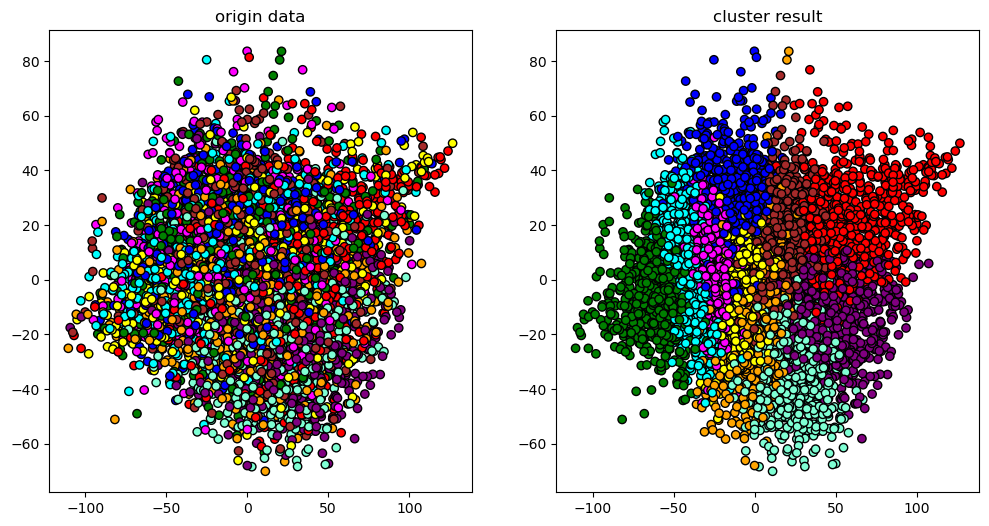

train time: 0.139415 s
execution time: 11.207625 s

acc: 0.202375
error: 0.797625

macro precision_score: 0.2048468399735594
micro precision_score: 0.202375
weighted precision_score: 0.20457815505616322
every precision_score: [0.33518006 0.13157895 0.12386364 0.13172043 0.17416378 0.18661972
 0.20500596 0.13929785 0.31917632 0.3018617 ]

macro recall_score: 0.20279799826712433
micro recall_score: 0.202375
weighted recall_score: 0.202375
every recall_score: [0.30828025 0.11097411 0.14513981 0.11893204 0.19284802 0.19800747
 0.20451843 0.15129151 0.31352718 0.28446115]

confusion_matrix: [[242 132  33  40  26  23  26  47 142  74]
 [ 37  90 113 102  79  79  83  48 102  78]
 [ 96  41 109  93 104  57  76 113  37  25]
 [ 79  28  92  98  85 139 112 117  38  36]
 [ 31  21 104  83 151 106 109 119  28  31]
 [ 62  24 109  78  84 159 108 138  19  22]
 [ 67  12 109 153 148  69 172  90   9  12]
 [ 46  43  82  36 119 140  77 123  32 115]
 [ 29 187  48  36  20  45  23  23 248 132]
 [ 33 106  81  25  5

In [25]:
Deal('KMeans', 'tsne', X_train, Y_train, n_components=1, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

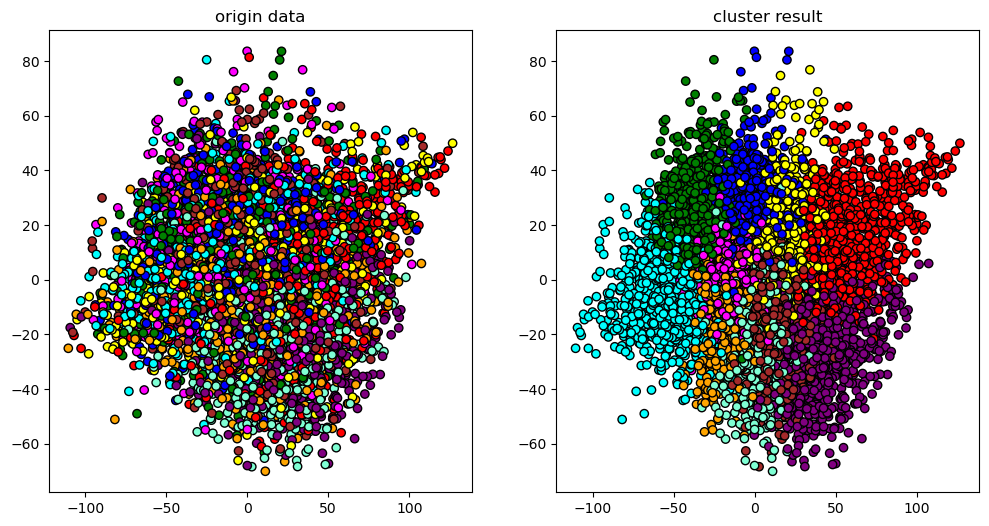

train time: 0.123752 s
execution time: 17.525113 s

acc: 0.211125
error: 0.788875

macro precision_score: 0.20721805697962642
micro precision_score: 0.211125
weighted precision_score: 0.20708511073378036
every precision_score: [0.30760234 0.17840376 0.14285714 0.15186246 0.18055556 0.22003035
 0.21020761 0.16331658 0.33632287 0.1810219 ]

macro recall_score: 0.21113532059298082
micro recall_score: 0.211125
weighted recall_score: 0.211125
every recall_score: [0.33503185 0.1405672  0.14380826 0.12864078 0.19923372 0.18057285
 0.28894174 0.1599016  0.37926675 0.15538847]

confusion_matrix: [[263  28  53  13  27  19  52  57 143 130]
 [ 63 114  34  51  57  44 154  92 100 102]
 [116  44 108  53 139  52 135  44  24  36]
 [ 86  54 107 106  86 107 145  85  28  20]
 [ 38  53 107 114 156  80 134  57  26  18]
 [ 65  67 101 113  94 145 127  70  10  11]
 [ 71  78  83  86 176  52 243  36   9   7]
 [ 54  60 105 112  88 107  73 130  49  35]
 [ 53  50  14  21  13  30  46  62 300 202]
 [ 46  91  44  29  

In [26]:
Deal('KMeans', 'tsne', X_train, Y_train, n_components=2, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

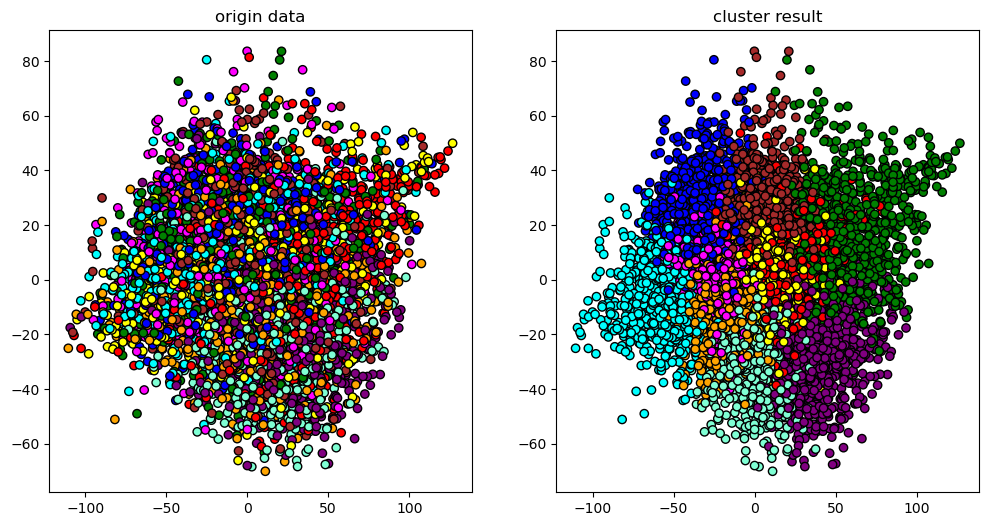

train time: 0.228291 s
execution time: 113.196864 s

acc: 0.20475
error: 0.79525

macro precision_score: 0.20491532576903654
micro precision_score: 0.20475
weighted precision_score: 0.20472471272165113
every precision_score: [0.25931446 0.18497914 0.1498708  0.11679644 0.18639798 0.18112245
 0.21304348 0.17088608 0.32668882 0.26005362]

macro recall_score: 0.20485534410810025
micro recall_score: 0.20475
weighted recall_score: 0.20475
every recall_score: [0.22165605 0.16399507 0.15446072 0.12742718 0.1890166  0.17683686
 0.23305589 0.16605166 0.37294564 0.24310777]

confusion_matrix: [[174  58  26 219  17  19  39  33 154  46]
 [ 60 133  50  66  34  74 122  53 102 117]
 [ 56  55 116 113 109  53 109  82  23  35]
 [ 44  47 105 105  90 113 127 115  22  56]
 [ 33  47  93  49 148 118 106 114  28  47]
 [ 45  67 102  81  89 142  94 138  12  33]
 [  9  83 110  83 166  89 196  67   8  30]
 [ 45  47  84  66 101 116  50 135  55 114]
 [158  95  14  58   6  33  39  19 295  74]
 [ 47  87  74  59  34  

In [27]:
Deal('KMeans', 'tsne', X_train, Y_train, n_components=3, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

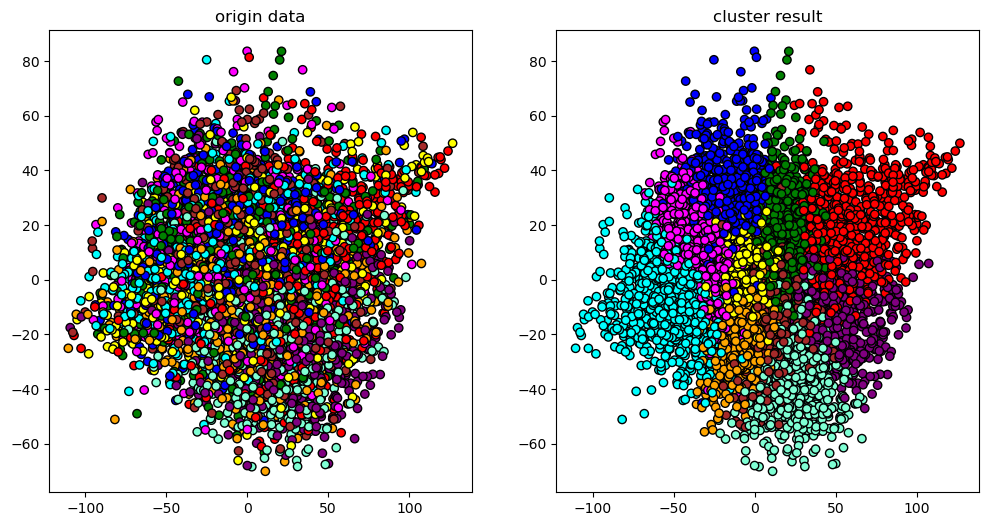

train time: 1.075078 s
execution time: 13.936581 s

acc: 0.207625
error: 0.792375

macro precision_score: 0.21127437263483126
micro precision_score: 0.207625
weighted precision_score: 0.21123636308298677
every precision_score: [0.31377551 0.18608414 0.13172338 0.1418637  0.17917448 0.18509317
 0.215311   0.18309859 0.30839416 0.26822558]

macro recall_score: 0.2075219319771139
micro recall_score: 0.207625
weighted recall_score: 0.207625
every recall_score: [0.3133758  0.14180025 0.15978695 0.12378641 0.24393359 0.18555417
 0.32104637 0.12792128 0.2136536  0.2443609 ]

confusion_matrix: [[246  51  31  50  24  25  61  87 104 106]
 [ 50 115  93  39  77  66 164  55  72  80]
 [106  29 120  95 121  60 141  37  20  22]
 [ 86  41 101 102 131 130 154  27  27  25]
 [ 35  40 123  90 191 106 134  21  20  23]
 [ 64  34 130 117 123 149 133  28  16   9]
 [ 68  32 126  65 196  61 270   9   7   7]
 [ 51  40 103  95 137 130  82 104  21  50]
 [ 37 103  31  31  19  42  48 101 169 210]
 [ 41 133  53  35  4

In [28]:
Deal('AgglomerativeClustering', 'tsne', X_train, Y_train, n_components=1, n_clusters=10)

<Figure size 1000x1200 with 0 Axes>

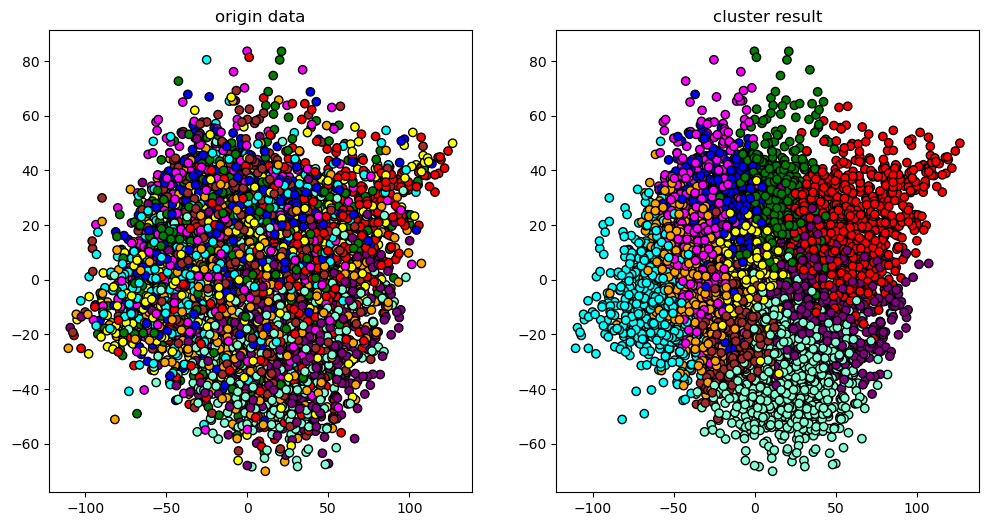

train time: 1.162458 s
execution time: 22.683914 s

acc: 0.207625
error: 0.792375

macro precision_score: 0.20045817644295125
micro precision_score: 0.207625
weighted precision_score: 0.20039497002234166
every precision_score: [0.28240741 0.14631336 0.12222222 0.15816327 0.21419829 0.21702838
 0.21985816 0.09841828 0.27105832 0.27491409]

macro recall_score: 0.20836599746732037
micro recall_score: 0.207625
weighted recall_score: 0.207625
every recall_score: [0.31082803 0.15659679 0.14647137 0.11286408 0.22349936 0.1618929
 0.1843044  0.06888069 0.31731985 0.40100251]

confusion_matrix: [[244  47  40  38  25  23  26  34 181 127]
 [ 53 127  90  30  59  50  72  93  97 140]
 [123  70 110  69  91  47 100  36  74  31]
 [ 93  98  99  93  86  88 104  59  56  48]
 [ 40  77 123  89 175  57  93  39  53  37]
 [ 80 106 104 104  78 130  76  47  49  29]
 [ 77 150 123  58 141  61 155  40  18  18]
 [ 68  80 103  76 113  75  39  56  45 158]
 [ 39  61  41  17  15  40  14  57 251 256]
 [ 47  52  67  14  3

In [29]:
Deal('AgglomerativeClustering', 'tsne', X_train, Y_train, n_components=2, n_clusters=10)

In [ ]:
Deal('AgglomerativeClustering', 'tsne', X_train, Y_train, n_components=3, n_clusters=10)